In [19]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import random
plt.style.use('fivethirtyeight')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


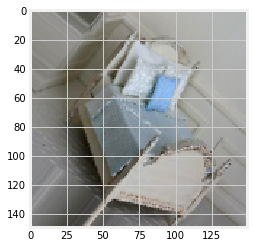

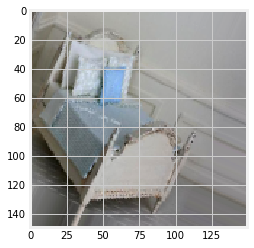

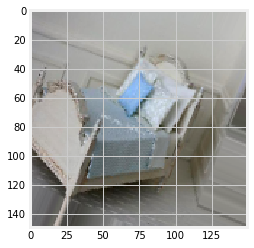

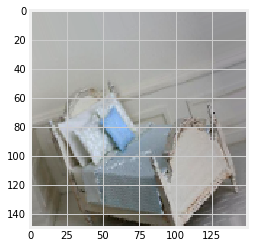

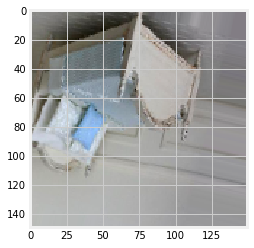

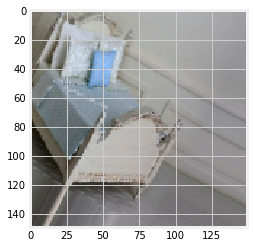

In [3]:
# Data Augmentation
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

base_dir = 'C:/Users/zzang/Desktop/archive/img/'
train_dir = os.path.join(base_dir, 'train/')
validation_dir = os.path.join(base_dir, 'val/')

# Directory with our training pictures
train_bed_dir = os.path.join(train_dir, 'bed')
train_chair_dir = os.path.join(train_dir, 'chair')
train_sofa_dir = os.path.join(train_dir, 'sofa')
train_swivelchair_dir = os.path.join(train_dir, 'swivelchair')
train_table_dir = os.path.join(train_dir, 'table')

# Directory with our validation pictures
validation_bed_dir = os.path.join(validation_dir, 'bed')
validation_chair_dir = os.path.join(validation_dir, 'chair')
validation_sofa_dir = os.path.join(validation_dir, 'sofa')
validation_swivelchair_dir = os.path.join(validation_dir, 'swivelchair')
validation_table_dir = os.path.join(validation_dir, 'table')

train_bed_fnames = os.listdir(train_bed_dir)
train_chair_fnames = os.listdir(train_chair_dir)
train_sofa_fnames = os.listdir(train_sofa_dir)
train_swivelchair_fnames = os.listdir(train_swivelchair_dir)
train_table_fnames = os.listdir(train_table_dir)

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_bed_dir, train_bed_fnames[0])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i > 5:
        break

In [11]:
batch_size = 20
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 4024 images belonging to 5 classes.
Found 423 images belonging to 5 classes.


In [20]:
from keras import regularizers

In [27]:
# l2_loss_lambda = 0.00010
# l2 = None if l2_loss_lambda is None else regularizers.l2(l2_loss_lambda)
# if l2 is not None:
#     print('Using L2 regularization - l2_loss_lambda = %.7f' % l2_loss_lambda)

# Build a model
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), input_shape = (150, 150, 3), 
                 activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, kernel_size = (3, 3), 
                 activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, kernel_size = (3, 3), 
                 activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))
# Dropout 0.25
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=0.001),
             metrics=['accuracy'])

# 모델 최적화 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=2, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 5)

# 모델 실행
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.n//batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.n//batch_size,
      callbacks=[early_stopping_callback, checkpointer],
      verbose=0)


Epoch 00001: val_loss improved from inf to 1.28170, saving model to ./model\01-1.2817.hdf5

Epoch 00002: val_loss improved from 1.28170 to 1.11849, saving model to ./model\02-1.1185.hdf5

Epoch 00003: val_loss improved from 1.11849 to 0.96527, saving model to ./model\03-0.9653.hdf5

Epoch 00004: val_loss improved from 0.96527 to 0.92488, saving model to ./model\04-0.9249.hdf5

Epoch 00005: val_loss improved from 0.92488 to 0.91973, saving model to ./model\05-0.9197.hdf5

Epoch 00006: val_loss did not improve from 0.91973

Epoch 00007: val_loss improved from 0.91973 to 0.83369, saving model to ./model\07-0.8337.hdf5

Epoch 00008: val_loss did not improve from 0.83369

Epoch 00009: val_loss improved from 0.83369 to 0.80834, saving model to ./model\09-0.8083.hdf5

Epoch 00010: val_loss improved from 0.80834 to 0.76129, saving model to ./model\10-0.7613.hdf5

Epoch 00011: val_loss did not improve from 0.76129

Epoch 00012: val_loss did not improve from 0.76129

Epoch 00013: val_loss impro

In [28]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9248)             

In [22]:
print('Test Accuracy: %.4f' % (model.evaluate(validation_generator)[1]))

22/22 [==============================] - 1s 52ms/step - loss: 1.4953 - accuracy: 0.6714
Test Accuracy: 0.6714


In [29]:
model.evaluate(validation_generator)

22/22 [==============================] - 1s 51ms/step - loss: 0.6083 - accuracy: 0.7991


[0.6083472967147827, 0.7990543842315674]

In [6]:
model.evaluate(validation_generator)

15/15 [==============================] - 1s 84ms/step - loss: 0.4711 - accuracy: 0.8322


[0.4711103141307831, 0.8321512937545776]

In [6]:
print('Test Accuracy: %.4f' % (model.evaluate(validation_generator)[1]))

22/22 [==============================] - 1s 44ms/step - loss: 0.4591 - accuracy: 0.8369
Test Accuracy: 0.8369


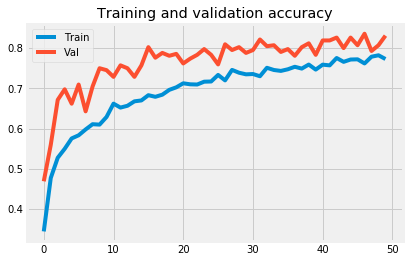

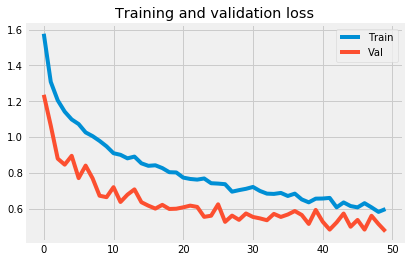

In [7]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['Train', 'Val'], loc='upper right')

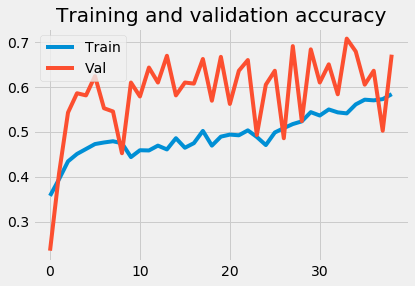

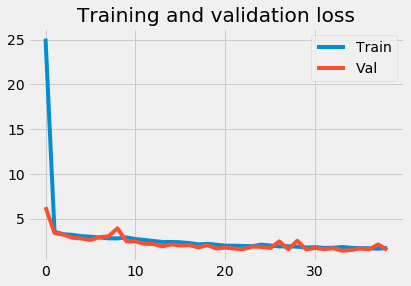

In [23]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['Train', 'Val'], loc='upper right')